The input data for this file is in **.txt** file, we split it into different list by detecting **'\n'**

The workflow is Tokenizer ---> RNN process ---> Padding ---> Embedding ---> LSTM 

In [3]:
import tensorflow.compat.v1 as tf        # Migrate your TensorFlow 1 code to TensorFlow 2
tf.disable_v2_behavior()

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

# tokenize the corpus
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1                                      # adding 1 is for <OOV> 

# create input sequences using list of tokens                                    # process the data for RNN
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):                                            # for loop make n-gram data lists,[[a],[a,b],[a,b,c]...]
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)
    
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])                        # make the lengths of sublist uniform      
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors = input_sequences[:,:-1]                                              # make the last letter of each list as output(label), and
label = input_sequences[:,-1]                                                    # and the rest is the input               
label = ku.to_categorical(label, num_classes=total_words)                        # each word is one kind of label

print(input_sequences[0:3])
print(input_sequences.shape)
print(predictors[0:3])
print(label[0:3])
print(label.shape)

--2019-10-26 20:01:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-10-26 20:01:39 (59.8 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]

[[  0   0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0   0  34 417 877]
 [  0   0   0   0   0   0   0  34 417 877 166]]
(15462, 11)
[[  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0  34 417 877]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(15462, 3211)


In [5]:
model = Sequential()                                                                  
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (N

In [6]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 31s 2ms/sample - loss: 6.8982 - acc: 0.0217
Epoch 2/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 6.5052 - acc: 0.0226
Epoch 3/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 6.3820 - acc: 0.0250
Epoch 4/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 6.2579 - acc: 0.0303
Epoch 5/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 6.1642 - acc: 0.0354
Epoch 6/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 6.0820 - acc: 0.0404
Epoch 7/100
15462/15462 [==============================] - 28s 2ms/sample - loss: 5.9975 - acc: 0.0431
Epoch 8/100
15462/15462 [==============================] - 29s 2ms/sample - loss: 5.9117 - acc: 0.0457
Epoch 9/100
15462/15462 [==============================] - 

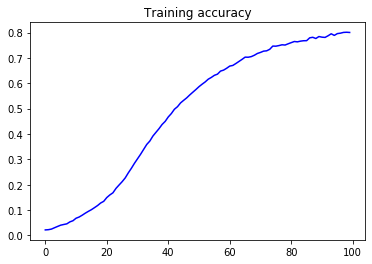

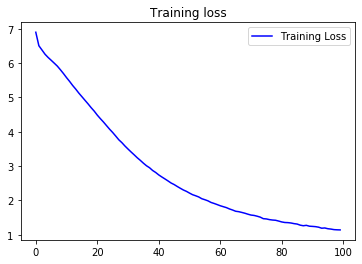

In [7]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [8]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope you lies some near curious days must be twain young seen kings aside slain 'will ' add at men pleasure some change so still doth kings friend foes tend foes aside foes every gems gems part another muse express'd express'd rare strife rare muse must one respect dost remain muse must room be substance another ill ill in thee more thy true will kings done done press be bad in so and shame with you be more or one shall dwell in done thee be dwell in time in thee as wanting and they be increase express'd must be be
